<a href="https://colab.research.google.com/github/PrayagPanta/ComprehensiveNoteTakerApp/blob/master/RAG_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Change Type of Runtime to use GPU.**

**RAG Workflow**

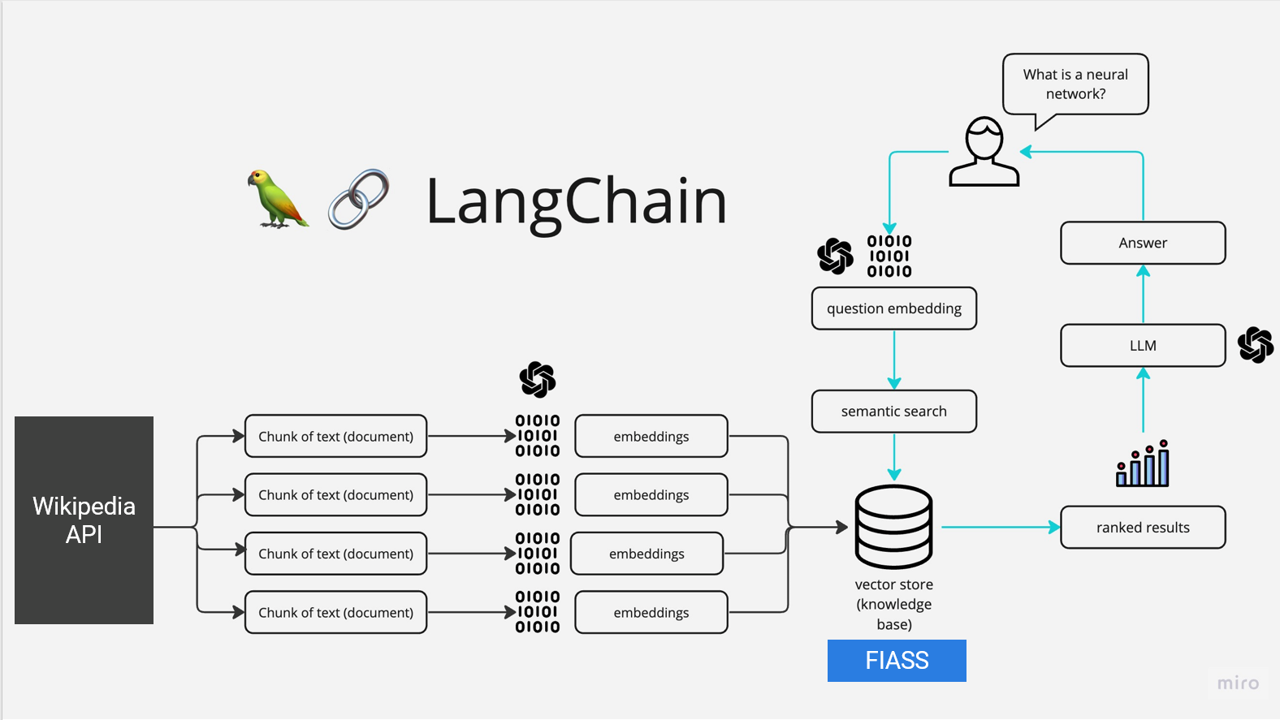

**Install Required Dependencies:**

In [1]:
!pip install -i https://pypi.org/simple/ bitsandbytes==0.43.1
!pip install accelerate==0.32.1
!pip install transformers==4.42.3
!pip install torch==2.3.1
!pip install langchain==0.2.6
!pip install huggingface_hub==0.23.4
!pip install langchain_huggingface==0.0.3

Looking in indexes: https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.8 MB/s eta 0:00:00


**3) Verify that GPU is being used**

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


**4) Download Model**

In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [26]:

import transformers

#model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model= "microsoft/Phi-3-mini-4k-instruct",
    # The quantization line
    model_kwargs={"torch_dtype": torch.bfloat16, "load_in_4bit": True},
    max_new_tokens=2048  # Increase the max tokens to your desired value
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**5) Create Pipeline**

In [4]:
from langchain_huggingface.llms import HuggingFacePipeline
hf = HuggingFacePipeline(pipeline=pipeline)

**6) Install Wikipedia API:**

In [5]:
!pip install wikipedia-api==0.6.0

In [6]:
import wikipediaapi

def fetch_wikipedia_article(article_title):
    wiki_wiki = wikipediaapi.Wikipedia('Wikipedia RAG Demo/1.0()', 'en')
    page = wiki_wiki.page(article_title)
    if page.exists():
        return page.text
    else:
        return ""

# Example usage
article_title = "Generative artificial intelligence"
wiki_text = fetch_wikipedia_article(article_title)

**8)Install Vector DB:**

In [7]:
!pip install faiss-cpu==1.8.0.post1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.7 MB/s eta 0:00:00


**9)Create embeddings and Save to Vector DB:**

In [22]:
import faiss
import transformers
import numpy as np
import torch

# Function to generate embeddings
def generate_embeddings(texts, model_name='sentence-transformers/paraphrase-MiniLM-L6-v2'):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1).numpy()

    return embeddings

# Generate embeddings for the Wikipedia text
sentences = wiki_text.split('\n')  # Split the text into sentences
embeddings = generate_embeddings(sentences)

# Create a FAISS index and add the embeddings
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(np.array(embeddings))

# Function to perform similarity search
def search_index(query, top_k=5):
    query_embedding = generate_embeddings([query])
    distances, indices = index.search(np.array(query_embedding), top_k)
    return [sentences[i] for i in indices[0]]


**10)Final Step**

**Without RAG:**

In [29]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Create the HuggingFacePipeline
hf = HuggingFacePipeline(pipeline=pipeline)

# Define your prompt template
template = """
Task :Answer the Question Asked<|end|>
Question: {question}<|end|>
Answer: """
prompt_template = PromptTemplate.from_template(template)

chain = prompt_template | hf

question = "Please generate history of Generative Artificial Intelligence."

print(chain.invoke({"question": question}))


Task :Answer the Question Asked<|end|> 
Question: Please generate history of Generative Artificial Intelligence.<|end|>
Answer: 

The history of Generative Artificial Intelligence (GAI) can be traced back to the early days of computing and artificial intelligence. Here's a brief overview:

1. Early Concepts (1950s-1960s): The concept of generative art, which involves creating art through algorithms and computational processes, can be traced back to the early days of computing. In the 1950s and 1960s, pioneers like John McCarthy and Marvin Minsky were working on early AI systems, laying the groundwork for generative techniques.

2. Computer Art (1960s-1970s): The first computer art exhibitions took place in the 1960s, showcasing the potential of generative art. Artists like Georg Nees and Frieder Nake were creating algorithmic art using computers, demonstrating the intersection of art and technology.

3. Fractal Art (1970s-1980s): In the 1970s and 1980s, fractal art emerged as a popula

**With RAG:**

In [30]:
template = template = """
Task :Answer the Question Asked. Also make use of context while answering the question<|end|>
Context:{context}<|end|>
Question: {question}<|end|>
Answer: """
prompt_template_for_rag = PromptTemplate.from_template(template)

def rag_generate(question):
    context = "\n".join(search_index(question))
    llm_chain = LLMChain(llm=hf, prompt=prompt_template_for_rag)
    result = llm_chain.run({"context": context, "question": question})
    return result

question = "Please generate history of Generative Artificial Intelligence."
answer = rag_generate(question)
print(answer)


Task :Answer the Question Asked. Also make use of context while answering the question<|end|> 
Context:Artificial Intelligence is an idea that has been captivating society since the mid-20th century. It began with science fiction familiarizing the world with the concept but the idea was not fully seen in the scientific manner until Alan Turing, a polymath, was curious about the feasibility of the concept. Turing's groundbreaking 1950 paper, "Computing Machinery and Intelligence," posed fundamental questions about machine reasoning similar to human intelligence, significantly contributing to the conceptual groundwork of AI. The development of AI was not very rapid at first because of the high costs and the fact that computers were not able to store commands. This changed during the 1956 Dartmouth Summer Research Project on AI where there was an inspiring call for AI research, setting the precedent for two decades of rapid advancements in the field.
The academic discipline of artificial